##Download Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy import ndimage
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import shutil
import matplotlib.pyplot as plt
import cv2


##Load Data

In [2]:
test_df = pd.read_csv("D:\DL\Pneumothorax\siim-acr-pneumothorax\stage_1_test_images.csv")
train_df = pd.read_csv("D:\DL\Pneumothorax\siim-acr-pneumothorax\stage_1_train_images.csv")
image_folder = "D:\DL\Pneumothorax\siim-acr-pneumothorax\png_images"
mask_folder="D:\DL\Pneumothorax\siim-acr-pneumothorax\png_masks"


##Check Missing images


In [3]:

missing_images = [fname for fname in train_df['new_filename']
                  if not os.path.exists(os.path.join(image_folder, fname))]
print("Number of missing images: ", len(missing_images))



missing_masks = [fname for fname in train_df[train_df['has_pneumo'] == 1]['new_filename']
                 if not os.path.exists(os.path.join(mask_folder, fname))]
print("Number of missing Masks: ", len(missing_masks))


Number of missing images:  0
Number of missing Masks:  0


##Check UnBalance

In [4]:

zero_masks = 0
non_zero_masks = 0

for m in os.listdir(mask_folder):
    mask = np.array(Image.open(os.path.join(mask_folder, m)))
    if np.sum(mask) == 0:
        zero_masks += 1
    else:
        non_zero_masks += 1

print("\n=== DATA BALANCE CHECK ===")
print(f"Normal (no pneumonia) images  : {zero_masks}")
print(f"Pneumonia cases (with mask)    : {non_zero_masks}")
print(f"Ratio pneumonia : normal       : {non_zero_masks}/{zero_masks}")


=== DATA BALANCE CHECK ===
Normal (no pneumonia) images  : 9378
Pneumonia cases (with mask)    : 2669
Ratio pneumonia : normal       : 2669/9378


##Analyze The Data

In [5]:
def analyze_dataset(image_folder, mask_folder):
    image_sizes = set()
    mask_sizes = set()
    image_modes = set()
    mask_modes = set()

    binary_masks = 0
    non_binary_masks = 0
    binary_0255_masks = 0

    total_images = 0
    total_masks = 0


    for filename in os.listdir(image_folder):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            total_images += 1

            image = Image.open(os.path.join(image_folder, filename))
            image_sizes.add(image.size)
            image_modes.add(image.mode)

            mask_path = os.path.join(mask_folder, filename)
            if os.path.exists(mask_path):
                total_masks += 1
                mask = Image.open(mask_path)
                mask_sizes.add(mask.size)
                mask_modes.add(mask.mode)

                unique_values = np.unique(np.array(mask))

                if np.all(np.isin(unique_values, [0, 1])):
                    binary_masks += 1
                elif np.all(np.isin(unique_values, [0, 255])):
                    binary_0255_masks += 1
                else:
                    non_binary_masks += 1

    return {
        "total_images": total_images,
        "total_masks": total_masks,
        "image_sizes": image_sizes,
        "mask_sizes": mask_sizes,
        "image_modes": image_modes,
        "mask_modes": mask_modes,
        "binary_masks": binary_masks,
        "binary_0255_masks": binary_0255_masks,
        "non_binary_masks": non_binary_masks
    }


In [6]:
print(analyze_dataset(image_folder, mask_folder))

{'total_images': 12047, 'total_masks': 12047, 'image_sizes': {(1024, 1024)}, 'mask_sizes': {(1024, 1024)}, 'image_modes': {'L'}, 'mask_modes': {'L'}, 'binary_masks': 9378, 'binary_0255_masks': 2669, 'non_binary_masks': 0}


##Normalize Masks

In [7]:

from tqdm import tqdm


all_files = [f for f in os.listdir(mask_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

print(f"Starting Binarization for {len(all_files)} masks...")
print("Strategy: Normalize -> Fixed Threshold (0.5) -> Overwrite in same folder")

processed_count = 0
error_count = 0


for fname in tqdm(all_files):
    try:
        path = os.path.join(mask_folder, fname)


        img = Image.open(path).convert("L")
        arr = np.array(img)


        max_val = arr.max()

        if max_val == 0:
            binary_arr = arr.astype(np.uint8)
        else:
            norm_arr = arr / max_val
            binary_arr = (norm_arr > 0.5).astype(np.uint8)

        Image.fromarray(binary_arr * 255, mode="L").save(path)

        processed_count += 1

    except Exception as e:
        print(f"Error processing {fname}: {e}")
        error_count += 1


print("\n=== FINAL VERIFICATION ===")
print(f"Successfully processed: {processed_count}")
print(f"Errors: {error_count}")


if processed_count > 0:
    sample_file = all_files[0]
    sample_path = os.path.join(mask_folder, sample_file)
    sample_arr = np.array(Image.open(sample_path))
    unique_vals = np.unique(sample_arr)
    print(f"Sample check ({sample_file}) unique values: {unique_vals}")

    if np.array_equal(unique_vals, [0]) or np.array_equal(unique_vals, [1]) \
   or np.array_equal(unique_vals, [0, 1]) or np.array_equal(unique_vals, [0, 255]):
     print(" SUCCESS: Data is binary (Clean).")
else:
    print(" WARNING: Data still contains non-binary values!")




Starting Binarization for 12047 masks...
Strategy: Normalize -> Fixed Threshold (0.5) -> Overwrite in same folder


  0%|          | 0/12047 [00:00<?, ?it/s]C:\Users\RTC\AppData\Local\Temp\ipykernel_9856\4064539107.py:30: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(binary_arr * 255, mode="L").save(path)
100%|██████████| 12047/12047 [02:17<00:00, 87.36it/s] 


=== FINAL VERIFICATION ===
Successfully processed: 12047
Errors: 0
Sample check (0_test_1_.png) unique values: [  0 255]
 SUCCESS: Data is binary (Clean).


In [8]:
file_name = os.listdir(mask_folder)[3]
img_path = os.path.join(mask_folder, file_name)

img_arr = np.array(Image.open(img_path))
print(f"File: {file_name}")
print(f"Unique values inside image: {np.unique(img_arr)}")

File: 10001_train_0_.png
Unique values inside image: [0]


Check Corrupted Data

In [9]:
corrupted_images = []
corrupted_masks = []
blank_images = []
blank_masks = []

for filename in os.listdir(image_folder):
    if filename.endswith(".png"):
        img_path = os.path.join(image_folder, filename)
        msk_path = os.path.join(mask_folder, filename)

        try:
            img = Image.open(img_path)
            img_arr = np.array(img)
        except:
            corrupted_images.append(filename)
            continue

        if img_arr.min() == img_arr.max():
            blank_images.append(filename)

        try:
            mask = Image.open(msk_path)
            mask_arr = np.array(mask)
        except:
            corrupted_masks.append(filename)
            continue


        if np.all(mask_arr == 0):
            blank_masks.append(filename)


print("DATA QUALITY REPORT")
print("-----------------------------")
print("Corrupted Images:", len(corrupted_images))
print(corrupted_images[:10])
print("Corrupted Masks:", len(corrupted_masks))
print(corrupted_masks[:10])
print("Blank Images:", len(blank_images))
print("Masks with no segmentation:", len(blank_masks))
print("-----------------------------")


DATA QUALITY REPORT
-----------------------------
Corrupted Images: 0
[]
Corrupted Masks: 0
[]
Blank Images: 0
Masks with no segmentation: 9378
-----------------------------


In [10]:
import os
from PIL import Image
import numpy as np
import cv2
from scipy import ndimage
from tqdm import tqdm



total_masks = 0
binary_masks = 0
non_binary_masks = 0

lesion_areas = []
small_lesions_count = 0
large_lesions_count = 0
num_components_list = []


small_lesion_ratio = 0.05
high_res_threshold = 0.05

print("Starting Analysis...")

for filename in tqdm(os.listdir(mask_folder)):
    if not filename.endswith(".png"):
        continue
    total_masks += 1

    path = os.path.join(mask_folder, filename)


    mask = Image.open(path).convert("L")
    mask_arr = np.array(mask)


    mask_bin = (mask_arr > 127).astype(np.uint8)


    unique_vals = np.unique(mask_arr)


    is_clean_binary = np.all(np.isin(unique_vals, [0, 1, 255]))

    if is_clean_binary:
        binary_masks += 1
    else:
        non_binary_masks += 1

        _, mask_bin = cv2.threshold(mask_arr, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)



    area_ratio = np.sum(mask_bin) / mask_bin.size
    lesion_areas.append(area_ratio)


    if area_ratio < small_lesion_ratio:
        small_lesions_count += 1
    else:
        large_lesions_count += 1


    labeled, num_features = ndimage.label(mask_bin)
    num_components_list.append(num_features)

print("\n=== MASK ANALYSIS REPORT ===")
print(f"Total Masks Analyzed     : {total_masks}")
print(f"Clean Binary Masks       : {binary_masks}")
print(f"Non-binary / Noisy Masks : {non_binary_masks}")

if len(lesion_areas) > 0:
    print(f"\nLesion Area Statistics (as fraction of image size):")
    print(f"Average lesion area      : {np.mean(lesion_areas):.4f}")
    print(f"Min lesion area          : {np.min(lesion_areas):.4f}")
    print(f"Max lesion area          : {np.max(lesion_areas):.4f}")

    print(f"\nLesion Size Categories:")
    print(f"Small lesions (<{small_lesion_ratio*100:.0f}% of image)  : {small_lesions_count}")
    print(f"Large lesions (≥{small_lesion_ratio*100:.0f}%)         : {large_lesions_count}")

    print(f"\nConnected Components (Bubbles / Patches):")
    print(f"Average number of components per mask : {np.mean(num_components_list):.2f}")
    print(f"Min components per mask                 : {np.min(num_components_list)}")
    print(f"Max components per mask                 : {np.max(num_components_list)}")


    print("\n--- Recommendations based on analysis ---")
    if np.mean(lesion_areas) < small_lesion_ratio:
        print("Most lesions are small → use Zoom/Crop + High-Resolution (512+) + Dice/Focal Loss")
    else:
        print("Lesions are relatively large → 256x256 may be sufficient")
else:
    print("\nNo masks found or processed.")



Starting Analysis...


100%|██████████| 12047/12047 [06:08<00:00, 32.65it/s]


=== MASK ANALYSIS REPORT ===
Total Masks Analyzed     : 12047
Clean Binary Masks       : 12047
Non-binary / Noisy Masks : 0

Lesion Area Statistics (as fraction of image size):
Average lesion area      : 0.0030
Min lesion area          : 0.0000
Max lesion area          : 0.1539

Lesion Size Categories:
Small lesions (<5% of image)  : 11941
Large lesions (≥5%)         : 106

Connected Components (Bubbles / Patches):
Average number of components per mask : 0.42
Min components per mask                 : 0
Max components per mask                 : 23

--- Recommendations based on analysis ---
Most lesions are small → use Zoom/Crop + High-Resolution (512+) + Dice/Focal Loss


In [11]:
means = []
stds = []
noises = []


brightness_low = 0
brightness_optimal = 0
brightness_high = 0

contrast_low = 0
contrast_optimal = 0
contrast_high = 0

noise_zero = 0
noise_low = 0
noise_high = 0

brightness_low_thr = 50
brightness_high_thr = 150

contrast_low_thr = 30
contrast_high_thr = 70

noise_thr = 1.0

def estimate_noise(img_array):

    h, w = img_array.shape
    noise = np.mean(np.abs(img_array - np.roll(img_array, 1, axis=0)))
    noise += np.mean(np.abs(img_array - np.roll(img_array, 1, axis=1)))
    return noise / 2.0

print(f"Starting Image Analysis on: {image_folder}...")


for img_name in tqdm(os.listdir(image_folder)):

    if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img_path = os.path.join(image_folder, img_name)

    try:

        img = Image.open(img_path).convert("L")
        arr = np.array(img, dtype=np.float32)


        mean_val = np.mean(arr)
        std_val = np.std(arr)
        noise_val = estimate_noise(arr)

        means.append(mean_val)
        stds.append(std_val)
        noises.append(noise_val)




        if mean_val < brightness_low_thr:
            brightness_low += 1
        elif mean_val > brightness_high_thr:
            brightness_high += 1
        else:
            brightness_optimal += 1


        if std_val < contrast_low_thr:
            contrast_low += 1
        elif std_val > contrast_high_thr:
            contrast_high += 1
        else:
            contrast_optimal += 1


        if noise_val == 0:
            noise_zero += 1
        elif noise_val <= noise_thr:
            noise_low += 1
        else:
            noise_high += 1

    except Exception as e:
        print(f"Error reading {img_name}: {e}")

total_imgs = len(means)
print("\n=== IMAGE QUALITY ANALYSIS REPORT ===")
print(f"Total Images Analyzed: {total_imgs}")

print("\n1. Intensity (Brightness) Statistics:")
print(f"   Mean Brightness : {np.mean(means):.2f} (Min: {np.min(means):.1f} | Max: {np.max(means):.1f})")
print(f"   ------------------------------------------------")
print(f"   Low (<{brightness_low_thr})      : {brightness_low} ({brightness_low/total_imgs*100:.1f}%)")
print(f"   Optimal         : {brightness_optimal} ({brightness_optimal/total_imgs*100:.1f}%)")
print(f"   High (>{brightness_high_thr})     : {brightness_high} ({brightness_high/total_imgs*100:.1f}%)")

print("\n2. Contrast Statistics:")
print(f"   Mean Contrast   : {np.mean(stds):.2f} (Min: {np.min(stds):.1f} | Max: {np.max(stds):.1f})")
print(f"   ------------------------------------------------")
print(f"   Low (<{contrast_low_thr})       : {contrast_low} ({contrast_low/total_imgs*100:.1f}%)")
print(f"   Optimal         : {contrast_optimal} ({contrast_optimal/total_imgs*100:.1f}%)")
print(f"   High (>{contrast_high_thr})      : {contrast_high} ({contrast_high/total_imgs*100:.1f}%)")

print("\n3. Noise Level Statistics:")
print(f"   Mean Noise      : {np.mean(noises):.4f} (Max: {np.max(noises):.4f})")
print(f"   ------------------------------------------------")
print(f"   Zero Noise (=0) : {noise_zero} ({noise_zero/total_imgs*100:.1f}%)")
print(f"   Low (≤{noise_thr})      : {noise_low} ({noise_low/total_imgs*100:.1f}%)")
print(f"   High (>{noise_thr})     : {noise_high} ({noise_high/total_imgs*100:.1f}%)")

print("\n=== RECOMMENDATION ===")
if brightness_low > brightness_high:
    print("Most images are Dark. Consider using 'CLAHE' or 'Gamma Correction' in transforms.")
elif brightness_high > brightness_low:
    print("Most images are Bright. Check if normalization is needed.")
else:
    print("Brightness distribution looks balanced.")

Starting Image Analysis on: D:\DL\Pneumothorax\siim-acr-pneumothorax\png_images...


100%|██████████| 12047/12047 [06:52<00:00, 29.19it/s]


=== IMAGE QUALITY ANALYSIS REPORT ===
Total Images Analyzed: 12047

1. Intensity (Brightness) Statistics:
   Mean Brightness : 125.05 (Min: 41.9 | Max: 229.1)
   ------------------------------------------------
   Low (<50)      : 6 (0.0%)
   Optimal         : 9984 (82.9%)
   High (>150)     : 2057 (17.1%)

2. Contrast Statistics:
   Mean Contrast   : 58.57 (Min: 12.7 | Max: 101.1)
   ------------------------------------------------
   Low (<30)       : 114 (0.9%)
   Optimal         : 10193 (84.6%)
   High (>70)      : 1740 (14.4%)

3. Noise Level Statistics:
   Mean Noise      : 1.7002 (Max: 5.3213)
   ------------------------------------------------
   Zero Noise (=0) : 0 (0.0%)
   Low (≤1.0)      : 352 (2.9%)
   High (>1.0)     : 11695 (97.1%)

=== RECOMMENDATION ===
Most images are Bright. Check if normalization is needed.


##Visualization

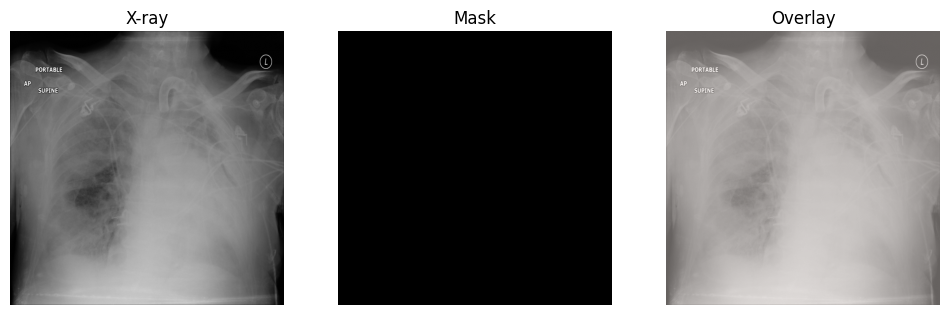

In [12]:

import os
import random
import cv2
import matplotlib.pyplot as plt

image_files = [f for f in os.listdir(image_folder) if f.endswith(".png")]

f = random.choice(image_files)


img = cv2.imread(os.path.join(image_folder, f), 0)
mask = cv2.imread(os.path.join(mask_folder, f), 0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("X-ray")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='Reds', alpha=0.4)
plt.axis("off")
plt.show()

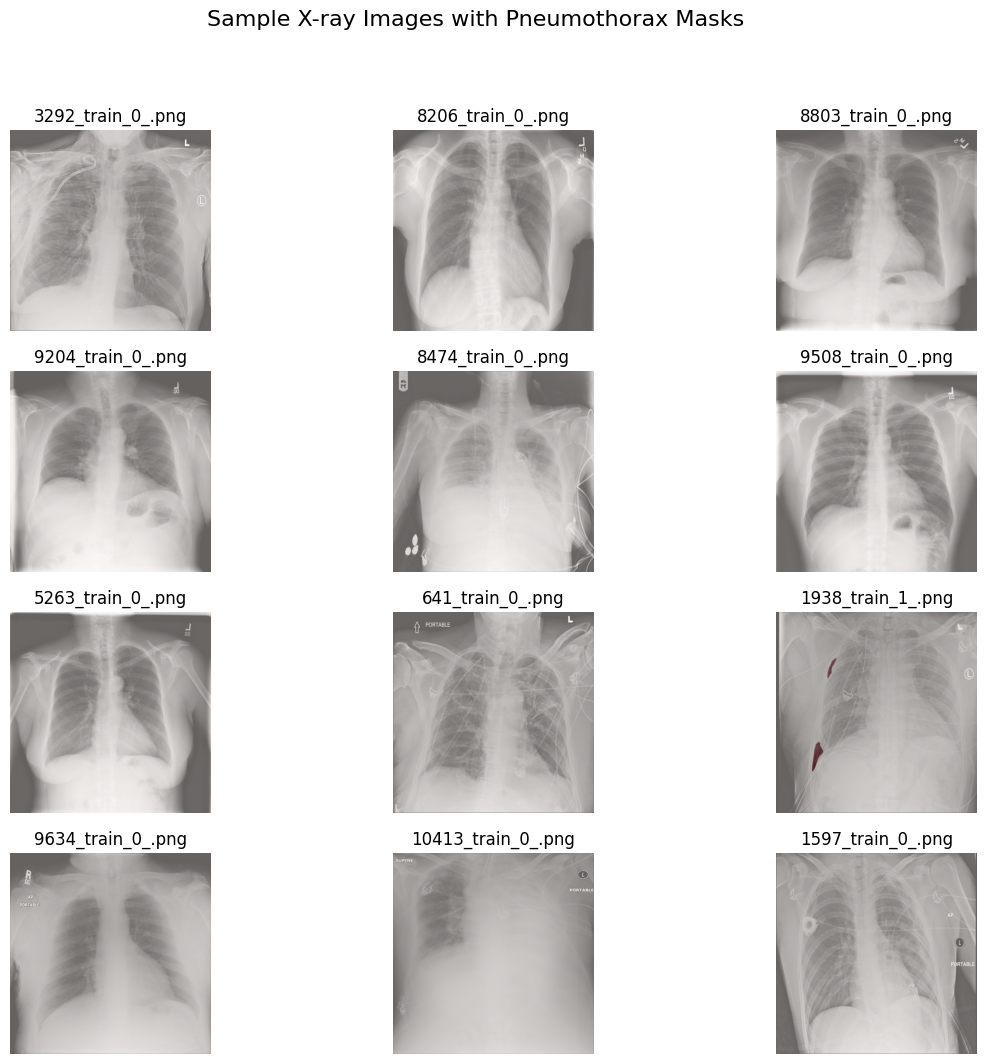

In [13]:
import os
import cv2
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(14,12))

for i in range(12):
    f = random.choice(image_files)

    img_path = os.path.join(image_folder, f)
    mask_path = os.path.join(mask_folder, f)

    img = cv2.imread(img_path, 0)
    mask = cv2.imread(mask_path, 0)

    if img is None or mask is None:
        print(f"Warning: Couldn't load {f}")
        continue

    plt.subplot(4,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.4)
    plt.title(f)
    plt.axis("off")

plt.suptitle("Sample X-ray Images with Pneumothorax Masks", fontsize=16)
plt.show()


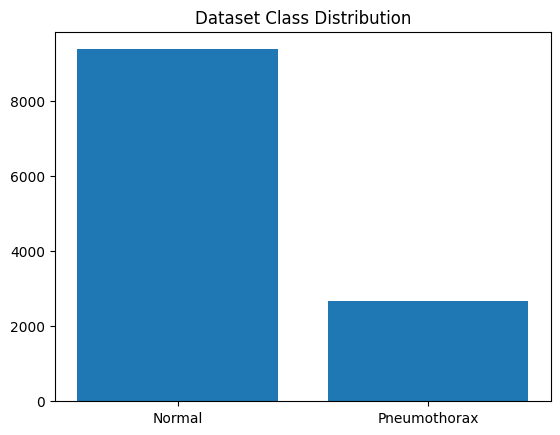

The number of Normal patients = 9378  
The number of Pneumothorax patients = 2669


In [14]:


count_mask = 0

for f in image_files:
    mask_path = os.path.join(mask_folder, f)
    mask = cv2.imread(mask_path, 0)

    if mask is None:
        print(f"Warning: Could not read mask {f}")
        continue

    if mask.sum() > 0:
        count_mask += 1

total = len(image_files)
no_mask = total - count_mask

plt.bar(["Normal", "Pneumothorax"], [no_mask, count_mask])
plt.title("Dataset Class Distribution")
plt.show()

print(f"The number of Normal patients = {no_mask} ",
      f"\nThe number of Pneumothorax patients = {count_mask}")


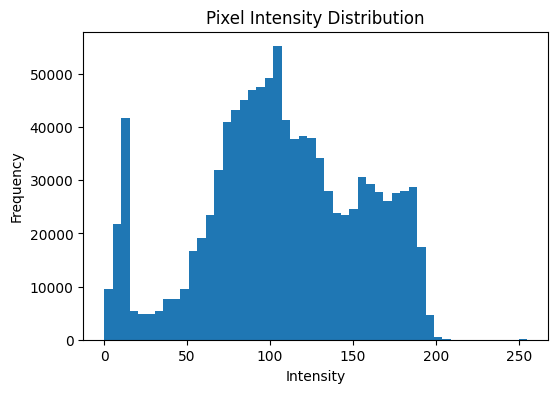

In [15]:


file_name = random.choice(image_files)
img_path = os.path.join(image_folder, file_name)

img = cv2.imread(img_path, 0)

if img is None:
    print(f"Warning: Could not read image {file_name}")
else:
    plt.figure(figsize=(6,4))
    plt.hist(img.ravel(), bins=50)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.show()


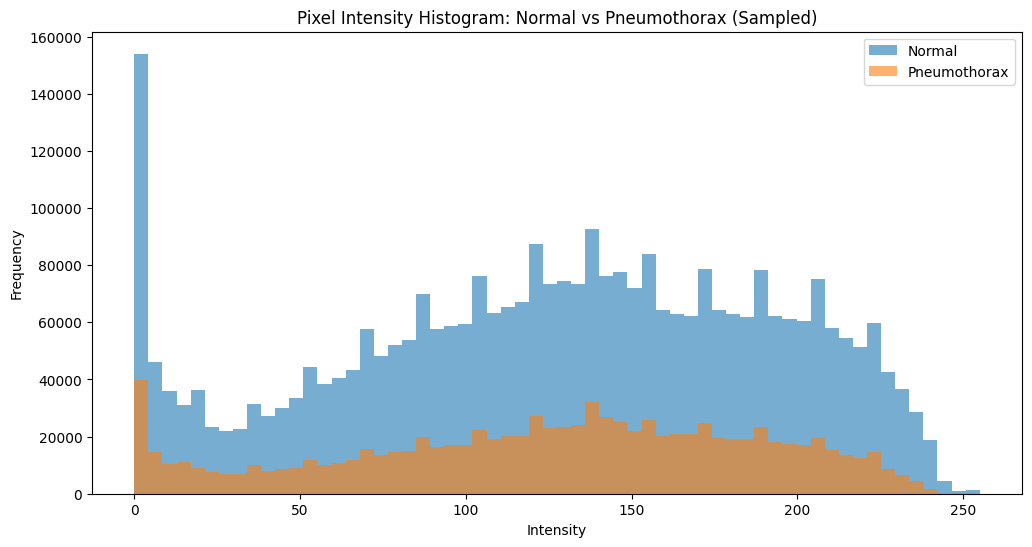

In [16]:
import random
sample_files = random.sample(image_files, 200)

normal_intensities = []
pneumo_intensities = []

for f in sample_files:
    img = cv2.imread(os.path.join(image_folder, f), 0)
    mask = cv2.imread(os.path.join(mask_folder, f), 0)

    if img is None or mask is None:
        continue

    if mask.sum() == 0:
        normal_intensities.extend(img.ravel()[::50])
    else:
        pneumo_intensities.extend(img.ravel()[::50])

plt.figure(figsize=(12,6))
plt.hist(normal_intensities, bins=60, alpha=0.6, label="Normal")
plt.hist(pneumo_intensities, bins=60, alpha=0.6, label="Pneumothorax")
plt.title("Pixel Intensity Histogram: Normal vs Pneumothorax (Sampled)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

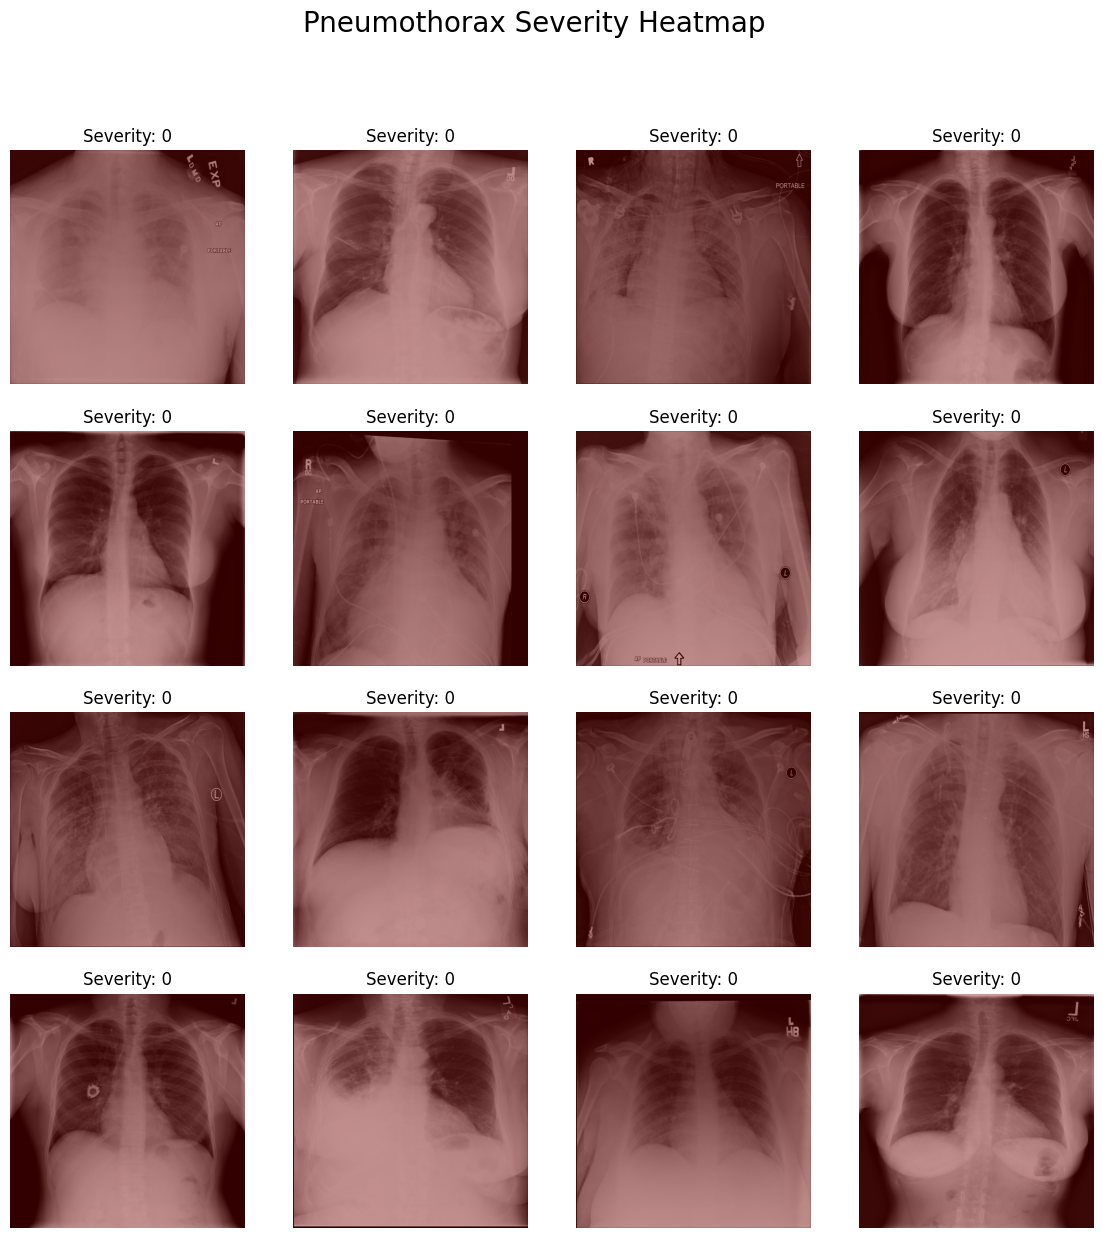

In [17]:
import numpy as np
sample_files = random.sample(image_files, 16)
def get_severity(mask):

    return np.count_nonzero(mask)

plt.figure(figsize=(14,14))

for i, f in enumerate(sample_files):
    img = cv2.imread(os.path.join(image_folder, f), 0)
    mask = cv2.imread(os.path.join(mask_folder, f), 0)

    if img is None or mask is None:
        continue

    severity = get_severity(mask)
    sev_norm = severity / (mask.shape[0] * mask.shape[1])


    heat_color = plt.cm.hot(sev_norm)


    color_mask = cv2.applyColorMap((mask > 0).astype('uint8') * 255, cv2.COLORMAP_JET)


    overlay = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), 0.6, color_mask, 0.4, 0)

    plt.subplot(4,4,i+1)
    plt.imshow(overlay, cmap='gray')
    plt.title(f"Severity: {severity}")
    plt.axis("off")

plt.suptitle("Pneumothorax Severity Heatmap", fontsize=20)
plt.show()


## AUGMENTATION


In [43]:
from torchvision.transforms import functional as F
from torchvision.transforms.functional import InterpolationMode


def Compose(functions):
    def apply(img, mask):
        for f in functions:
            img, mask = f(img, mask)
        return img, mask
    return apply

In [19]:
import random

def vflip(img, mask, p=0.5):
    if random.random() < p:
        img  = F.vflip(img)
        mask = F.vflip(mask)
    return img, mask


In [20]:
def random_brightness_contrast(img, mask, p=0.5):
    if random.random() < p:
        img = F.adjust_brightness(img, random.uniform(0.7, 1.3))
        img = F.adjust_contrast(img, random.uniform(0.7, 1.3))
    return img, mask

In [21]:
import torch
import numpy as np
from PIL import Image
import random

def gauss_noise(img, mask, var_limit=(5,20), p=0.5):
    if random.random() < p:

        if isinstance(img, Image.Image):
            img_tensor = torch.from_numpy(np.array(img)).unsqueeze(0).float() / 255
        else:
            img_tensor = img.clone()

        std = random.uniform(var_limit[0], var_limit[1]) / 255.0
        noise = torch.randn_like(img_tensor) * std
        img_tensor = torch.clamp(img_tensor + noise, 0, 1)


        img = Image.fromarray((img_tensor.squeeze(0).numpy()*255).astype(np.uint8))

    return img, mask


In [22]:
import numpy as np
import cv2
import random
from PIL import Image

def clahe(img, mask, clip_limit=2.0, p=0.5):
    if random.random() < p:

        if isinstance(img, Image.Image):
            np_img = np.array(img)
        else:
            np_img = img.copy()


        clahe_fn = cv2.createCLAHE(clipLimit=clip_limit)
        np_img = clahe_fn.apply(np_img.astype(np.uint8))


        img = Image.fromarray(np_img)

    return img, mask




In [23]:
def random_affine(img, mask, degrees=10, translate=(0.05,0.05), scale=(0.95,1.05), shear=5, p=0.5):

    if random.random() < p:
        w, h = img.size

        # Random angle
        angle = random.uniform(-degrees, degrees)

        # Translation
        max_dx = translate[0] * w
        max_dy = translate[1] * h
        translations = (random.uniform(-max_dx, max_dx), random.uniform(-max_dy, max_dy))

        # Scale
        scale_factor = random.uniform(*scale)

        # Shear
        shear_angle = random.uniform(-shear, shear)

        # Apply affine to image
        img = F.affine(
            img,
            angle=angle,
            translate=translations,
            scale=scale_factor,
            shear=shear_angle,
            interpolation=InterpolationMode.BILINEAR
        )

        # Apply affine to mask
        mask = F.affine(
            mask,
            angle=angle,
            translate=translations,
            scale=scale_factor,
            shear=shear_angle,
            interpolation=InterpolationMode.NEAREST
        )

    # لو الشرط ما اتحققش → هيرجع الصورة والماسك زي ما هما
    return img, mask


In [24]:
positive_transforms = Compose([

    lambda img, mask: vflip(img, mask, p=0.5),
    lambda img, mask: random_brightness_contrast(img, mask, p=0.5),
    lambda img, mask: gauss_noise(img, mask, var_limit=(5,20), p=0.5),
    lambda img, mask: clahe(img, mask, clip_limit=2.0, p=0.4),
    lambda img, mask: random_affine(img, mask, degrees=10, translate=(0.05,0.05), scale=(0.95,1.05), shear=5, p=0.7),
])

In [25]:
negative_transforms = Compose([
    lambda img, mask: random_brightness_contrast(img, mask, p=0.3),
    lambda img, mask: gauss_noise(img, mask, var_limit=(2,10), p=0.2),
    lambda img, mask: vflip(img, mask, p=0.1),
])

### Data Loder

In [26]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset_by_filename(images_dir, masks_dir, output_dir, val_ratio=0.1):

    # Output folders
    train_img_dir = os.path.join(output_dir, "train/images")
    train_mask_dir = os.path.join(output_dir, "train/masks")
    val_img_dir   = os.path.join(output_dir, "val/images")
    val_mask_dir  = os.path.join(output_dir, "val/masks")
    test_img_dir = os.path.join(output_dir, "test/images")
    test_mask_dir = os.path.join(output_dir, "test/masks")

    for d in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, test_img_dir, test_mask_dir]:
        os.makedirs(d, exist_ok=True)

    # Filter only PNG images
    all_images = [f for f in os.listdir(images_dir) if f.lower().endswith(".png")]
    all_images.sort()

    # First split: train/test based on filename
    train_candidates = []
    test_files = []

    for img_name in all_images:
        if "train" in img_name.lower():
            train_candidates.append(img_name)
        elif "test" in img_name.lower():
            test_files.append(img_name)

    # Second split: train → train + validation
    train_files, val_files = train_test_split(
        train_candidates,
        test_size=val_ratio,
        random_state=42
    )

    # ---- Copy files ----
    def copy_list(files_list, img_dst, mask_dst):
        for img_name in files_list:
            img_path = os.path.join(images_dir, img_name)
            mask_path = os.path.join(masks_dir, img_name)

            if os.path.exists(mask_path):
                shutil.copy(img_path, os.path.join(img_dst, img_name))
                shutil.copy(mask_path, os.path.join(mask_dst, img_name))
            else:
                print(f"Missing mask: {img_name}")

    # Copy train
    copy_list(train_files, train_img_dir, train_mask_dir)

    # Copy val
    copy_list(val_files, val_img_dir, val_mask_dir)

    # Copy test
    copy_list(test_files, test_img_dir, test_mask_dir)

    print(" Dataset split into train / val / test successfully!")
    print(f"Train: {len(train_files)} images")
    print(f"Val:   {len(val_files)} images")
    print(f"Test:  {len(test_files)} images")


In [27]:
images_dir = "D:\DL\Pneumothorax\siim-acr-pneumothorax\png_images"
masks_dir  = "D:\DL\Pneumothorax\siim-acr-pneumothorax\png_masks"

output_dir = "D:\DL\spliting"
split_dataset_by_filename(images_dir, masks_dir,output_dir)

 Dataset split into train / val / test successfully!
Train: 9607 images
Val:   1068 images
Test:  1372 images


In [28]:
class PneumothoraxDataset(Dataset):
    def __init__(self, images_dir, masks_dir, positive_transform=None, negative_transform=None, target_size=(224,224)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.target_size = target_size
        self.positive_transform = positive_transform
        self.negative_transform = negative_transform

        all_files = sorted(os.listdir(images_dir))
        self.files = []

        for f in all_files:
            img = cv2.imread(os.path.join(images_dir, f), 0)
            mask = cv2.imread(os.path.join(masks_dir, f), 0)
            if img is not None and mask is not None:
                self.files.append(f)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name)

        # Load grayscale
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize
        image = cv2.resize(image, self.target_size)
        mask  = cv2.resize(mask, self.target_size)

        # ----------------------
        #  APPLY AUGMENTATION HERE
        # ----------------------
        # Convert NumPy → PIL (لأن augmentations بتشتغل بالـ PIL)
        img_pil  = Image.fromarray(image)
        mask_pil = Image.fromarray(mask)

        if mask.sum() > 0:  # Positive mask
            if self.positive_transform:
                img_pil, mask_pil = self.positive_transform(img_pil, mask_pil)
        else:               # Negative mask
            if self.negative_transform:
                img_pil, mask_pil = self.negative_transform(img_pil, mask_pil)

        # Convert back to numpy
        image = np.array(img_pil)
        mask  = np.array(mask_pil)

        # ----------------------
        # Convert to tensors
        # ----------------------
        image_tensor = torch.from_numpy(image).float().unsqueeze(0) / 255.0
        mask_tensor  = torch.from_numpy(mask).float().unsqueeze(0)
        mask_tensor  = (mask_tensor > 0).float()

        return image_tensor, mask_tensor

In [29]:

def create_dataloaders(train_img_dir, train_mask_dir,
                      val_img_dir, val_mask_dir, test_img_dir, test_mask_dir,positive_transform,negative_transform,
                       batch_size=8):
    """
    Create DataLoaders for training and testing
    """
    # Create datasets
    train_dataset = PneumothoraxDataset(
    train_img_dir,
    train_mask_dir,
    positive_transform,
    negative_transform
    )
    val_dataset = PneumothoraxDataset(
    val_img_dir,
    val_mask_dir,
    positive_transform=None,
    negative_transform=None
    )
    test_dataset = PneumothoraxDataset(
        images_dir=test_img_dir,
        masks_dir=test_mask_dir,
        positive_transform=None,
        negative_transform=None
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    vali_loader= DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    print(f" Training samples: {len(train_dataset)}")
    print(f" Validation samples: {len(val_dataset)}")
    print(f" Testing samples: {len(test_dataset)}")
    print(f" Training batches: {len(train_loader)}")
    print(f" Validation batches: {len(vali_loader)}")
    print(f" Testing batches: {len(test_loader)}")

    return train_loader, vali_loader, test_loader

In [30]:
train_loader, vali_loader, test_loader = create_dataloaders (r"D:\DL\spliting\train\images",r"D:\DL\spliting\train\masks",
     r"D:\DL\spliting\val\images",  r"D:\DL\spliting\val\masks", r"D:\DL\spliting\test\images", r"D:\DL\spliting\test\masks", positive_transforms, negative_transforms,  batch_size=8 )

 Training samples: 9607
 Validation samples: 1068
 Testing samples: 1372
 Training batches: 1200
 Validation batches: 134
 Testing batches: 172


# Modeling

### Swin Tiny Encoder

In [31]:
import torch
import torch.nn as nn
from torchvision.models import swin_t, Swin_T_Weights
from torchvision import transforms

class SwinTinyGrayEncoder(nn.Module):
    """
    Encoder for grayscale medical images
    - Adds a small CNN to convert 1 channel -> 3 channels
    - Resizes images to 224x224
    - Normalizes with ImageNet mean/std
    - Uses pretrained Swin-Tiny as feature extractor
    """
    def __init__(self, pretrained=True):
        super().__init__()

        # Small CNN to convert 1 channel -> 3 channels
        self.gray2rgb = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Load pretrained weights
        weights = Swin_T_Weights.IMAGENET1K_V1 if pretrained else None
        self.model = swin_t(weights=weights)

        # Extract encoder (feature extractor only)
        self.encoder = self.model.features

        # Output channels of each stage
        self.out_channels = [96, 192, 384, 768]


    def forward(self, x):
        """
        x: tensor (B, 1, H, W) grayscale images
        returns: list of 4 feature maps from Swin Tiny
        """
        # Step 1: Convert 1 channel -> 3 channels
        x = self.gray2rgb(x)

        # Step 2: Pass through encoder stages
        features = []

      # 1. Patch Embedding + Stage 1 Blocks
        x = self.encoder[0](x) # Patch Embedding
        x = self.encoder[1](x) # Stage 1 Blocks
        features.append(x)     # مخرج Stage 1 (64x64, 96C لـ 256x256)

        # 2. Patch Merging + Stage 2 Blocks
        x = self.encoder[2](x) # Patch Merging
        x = self.encoder[3](x) # Stage 2 Blocks
        features.append(x)     # مخرج Stage 2 (32x32, 192C)

        # 3. Patch Merging + Stage 3 Blocks
        x = self.encoder[4](x) # Patch Merging
        x = self.encoder[5](x) # Stage 3 Blocks
        features.append(x)     # مخرج Stage 3 (16x16, 384C)

        # 4. Patch Merging + Stage 4 Blocks
        x = self.encoder[6](x) # Patch Merging
        x = self.encoder[7](x) # Stage 4 Blocks
        features.append(x)     # مخرج Stage 4 (8x8, 768C)

        features_fixed = []
        for feat in features:
            # تحقق من الشكل أولاً
            if feat.dim() == 4:
                # إذا كان (B, H, W, C) حول إلى (B, C, H, W)
                if feat.shape[-1] in [96, 192, 384, 768]:
                    feat = feat.permute(0, 3, 1, 2).contiguous()
            features_fixed.append(feat)

        return features_fixed

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = SwinTinyGrayEncoder(pretrained=True).to(device)

# مثال على batch من صور grayscale
# batch_size=2, H=256, W=256
x = torch.randn(2, 1, 224, 224).to(device)

features = encoder(x)

for i, f in enumerate(features):
    print(f"Stage {i+1} feature shape: {f.shape}")

Stage 1 feature shape: torch.Size([2, 96, 56, 56])
Stage 2 feature shape: torch.Size([2, 192, 28, 28])
Stage 3 feature shape: torch.Size([2, 384, 14, 14])
Stage 4 feature shape: torch.Size([2, 768, 7, 7])


###  UNetDecoder

In [41]:
import torch
import torch.nn as nn
# import torch.nn.functional as F


# --------------------------------
#  Basic Double Convolution Block
# --------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


# --------------------------------
#  Up Block with Skip Connection
# --------------------------------
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpBlock, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x, skip):
        # Upsample
        x = self.up(x)

        # Auto-padding لتفادي اختلاف الأحجام
        if x.size()[-2:] != skip.size()[-2:]:
            diffY = skip.size(2) - x.size(2)
            diffX = skip.size(3) - x.size(3)
            x = F.pad(x, [
                diffX // 2, diffX - diffX // 2,
                diffY // 2, diffY - diffY // 2
            ])

        # concatenate skip connection
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


# --------------------------------
#      U-Net Decoder for Swin-Tiny
# --------------------------------
class UNetDecoder(nn.Module):
    def __init__(self, encoder_channels, out_classes=1):
        """
        encoder_channels: [96, 192, 384, 768] from SwinTinyGrayEncoder
        """

        super(UNetDecoder, self).__init__()

        c1, c2, c3, c4 = encoder_channels

        # Decoder blocks
        self.up1 = UpBlock(c4 + c3, 384)      # 768 → 384
        self.up2 = UpBlock(384 + c2, 192)     # 384 → 192
        self.up3 = UpBlock(192 + c1, 96)      # 192 → 96

       # نحتاج 4 مرات upsampling:
       # 7x7 → 14x14 → 28x28 → 56x56 → 112x112 → 224x224

        # Additional upsampling layers
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(96, 48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.up5 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(48, 24, kernel_size=3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )

        # Final 1x1 conv to output mask
        self.final_conv = nn.Conv2d(24, out_classes, kernel_size=1)

    def forward(self, features):
        """
        features will come from encoder in this order:
        [f1, f2, f3, f4]
        """

        f1, f2, f3, f4 = features

        x = self.up1(f4, f3)
        x = self.up2(x, f2)
        x = self.up3(x, f1)

        x = self.up4(x)
        x = self.up5(x)


        mask = self.final_conv(x)


        return mask

###  SwinUNet

In [34]:
import torch
import torch.nn as nn

class SwinUNet(nn.Module):
    """
    Complete Swin-UNet model for Pneumothorax Segmentation
    Combines SwinTinyGrayEncoder + UNetDecoder
    """
    def __init__(self, num_classes=1, pretrained=True):
        super().__init__()

        # Encoder (Swin-Tiny)
        self.encoder = SwinTinyGrayEncoder(pretrained=pretrained)

        # Decoder (U-Net style)
        self.decoder = UNetDecoder(
            encoder_channels=self.encoder.out_channels,
            out_classes=num_classes
        )

    def forward(self, x):
        # Get features from encoder
        features = self.encoder(x)

        # Decode to segmentation mask
        mask = self.decoder(features)

        return mask

### Dice loss function

In [35]:
import torch.nn.functional as FU

def dice_loss(pred, target, smooth=1e-6):
    """
    Dice Loss that treats each image in the batch equally
    """
    pred = torch.sigmoid(pred)
    
    # Vectorized calculation (أسرع من loop)
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    
    intersection = (pred_flat * target_flat).sum(dim=1)
    union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)
    
    dice = (2. * intersection + smooth) / (union + smooth)
    
    # متوسط Dice لكل الصور في الـ batch
    return 1 - dice.mean()

def bce_dice_loss(pred, target, alpha=0.5):
    """
    Combined BCE and Dice loss
    """
    bce = FU.binary_cross_entropy_with_logits(pred, target)
    dice = dice_loss(pred, target)

    return alpha * bce + (1 - alpha) * dice

In [ ]:
def calculate_iou(pred, target, threshold=0.5):
    """
    Calculate mean IoU across batch (each image treated separately)
    """
    pred_binary = (torch.sigmoid(pred) > threshold).float()
    
    # Vectorized calculation (أسرع)
    intersection = (pred_binary * target).sum(dim=(1, 2, 3))  # (B,)
    union = pred_binary.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    
    ious = (intersection + 1e-6) / (union + 1e-6)
    
    return ious.mean().item()  # متوسط IoU لكل الصور



# def calculate_iou(pred, target, threshold=0.5, num_classes=2):
#     """
#     Calculate IoU for each class across the batch.
#     Class 0: Background
#     Class 1: Disease/Positive Class
#     """
#     pred_binary = (torch.sigmoid(pred) > threshold).float()
    
#     # Flatten the tensors to easily calculate counts
#     pred_flat = pred_binary.flatten(1)  # (B, H*W)
#     target_flat = target.flatten(1)    # (B, H*W)
    
#     ious = []
    
#     for cls in range(num_classes):
        
#         # Binary masks for the current class
#         pred_cls = (pred_flat == cls).float()
#         target_cls = (target_flat == cls).float()
        
#         # Calculate intersection and union for the current class
#         intersection = (pred_cls * target_cls).sum(dim=1)  # (B,)
        
#         union = pred_cls.sum(dim=1) + target_cls.sum(dim=1) - intersection
        
#         # Handle cases where union is zero (e.g., image is all background, and model predicts all background)
#         # Using 1e-6 for stability
#         iou_cls = (intersection + 1e-6) / (union + 1e-6)
        
#         ious.append(iou_cls.mean().item()) # Mean IoU for this class across the batch
        
#     return ious

### Train model

In [ ]:
import torch.optim as optim
from tqdm import tqdm

def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0
    total_iou = 0
    total_samples = 0


    pbar = tqdm(dataloader, desc="Training")
    for images, masks in pbar:
        # Move to device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        iou = calculate_iou(outputs, masks)


        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        total_iou += iou * batch_size
        total_samples += batch_size

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'iou': f'{iou:.4f}'
        })

        
    avg_loss = total_loss / total_samples
    avg_iou = total_iou / total_samples


    return avg_loss, avg_iou


In [ ]:

def validate_epoch(model, dataloader, criterion, device):
    """
    Validate for one epoch
    """
    model.eval()
    total_loss = 0
    total_iou = 0
    total_samples = 0


    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)


            loss = criterion(outputs, masks)
            iou = calculate_iou(outputs, masks)
            
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_iou += iou * batch_size
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_iou = total_iou / total_samples


    return avg_loss, avg_iou

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4, device='cuda', patience=10):
    model = model.to(device)
    criterion = bce_dice_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}

    best_val_iou = 0.0
    no_improve = 0  # counter للـ early stopping

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # ---- Train ----
        train_loss, train_iou = train_epoch(model, train_loader, optimizer, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_iou'].append(train_iou)
        print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")

        # ---- Validate ----
        val_loss, val_iou = validate_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

        # ---- حفظ أفضل موديل بناءً على validation فقط ----
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            no_improve = 0
            torch.save(model.state_dict(), 'best_swin_unet.pth')
            print(f" Saved best model with Val IoU: {val_iou:.4f}")
        else:
            no_improve += 1
            print(f" No improvement: {no_improve}/{patience}")
            if no_improve >= patience:
                print(" Early stopping triggered.")
                break

    return model, history

In [44]:
# Main script
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create model
    model = SwinUNet(num_classes=1, pretrained=True)
    
    # Train model - باستخدام الـ dataloaders المحددة مسبقاً
    model, history = train_model(
        model=model,
        train_loader=train_loader,  # هذا الـ dataloader الذي قمت بإنشائه مسبقاً
        val_loader=vali_loader,     # تستخدم vali_loader الذي قمت بإنشائه في create_dataloaders
        num_epochs=50,
        lr=1e-4,
        device=device
    )


Epoch 1/50


Training: 100%|██████████| 1200/1200 [18:57<00:00,  1.05it/s, loss=0.6252, iou=0.2500]


Train Loss: 0.6920, Train IoU: 0.5331


Validation: 100%|██████████| 134/134 [01:00<00:00,  2.20it/s]


Val Loss: 0.6286, Val IoU: 0.7697
 Saved best model with Val IoU: 0.7697

Epoch 2/50


Training: 100%|██████████| 1200/1200 [15:04<00:00,  1.33it/s, loss=0.5583, iou=0.8750]


Train Loss: 0.5878, Train IoU: 0.7780


Validation: 100%|██████████| 134/134 [00:46<00:00,  2.89it/s]


Val Loss: 0.5562, Val IoU: 0.7697
 No improvement: 1/10

Epoch 3/50


Training: 100%|██████████| 1200/1200 [14:59<00:00,  1.33it/s, loss=0.5258, iou=0.6405]


Train Loss: 0.5380, Train IoU: 0.6791


Validation: 100%|██████████| 134/134 [00:46<00:00,  2.88it/s]


Val Loss: 0.5274, Val IoU: 0.7198
 No improvement: 2/10

Epoch 4/50


Training: 100%|██████████| 1200/1200 [15:36<00:00,  1.28it/s, loss=0.5033, iou=0.6550]


Train Loss: 0.5117, Train IoU: 0.5277


Validation: 100%|██████████| 134/134 [00:46<00:00,  2.86it/s]


Val Loss: 0.5151, Val IoU: 0.7119
 No improvement: 3/10

Epoch 5/50


Training: 100%|██████████| 1200/1200 [15:05<00:00,  1.33it/s, loss=0.3971, iou=0.4732]


Train Loss: 0.4934, Train IoU: 0.5237


Validation: 100%|██████████| 134/134 [00:48<00:00,  2.75it/s]


Val Loss: 0.5079, Val IoU: 0.6804
 No improvement: 4/10

Epoch 6/50


Training: 100%|██████████| 1200/1200 [15:04<00:00,  1.33it/s, loss=0.4537, iou=0.6009]


Train Loss: 0.4837, Train IoU: 0.4930


Validation: 100%|██████████| 134/134 [00:45<00:00,  2.92it/s]


Val Loss: 0.4984, Val IoU: 0.6005
 No improvement: 5/10

Epoch 7/50


Training: 100%|██████████| 1200/1200 [14:59<00:00,  1.33it/s, loss=0.4684, iou=0.4486]


Train Loss: 0.4791, Train IoU: 0.4126


Validation: 100%|██████████| 134/134 [00:47<00:00,  2.84it/s]


Val Loss: 0.4832, Val IoU: 0.2518
 No improvement: 6/10

Epoch 8/50


Training: 100%|██████████| 1200/1200 [14:59<00:00,  1.33it/s, loss=0.4876, iou=0.1562]


Train Loss: 0.4769, Train IoU: 0.4475


Validation: 100%|██████████| 134/134 [00:47<00:00,  2.85it/s]


Val Loss: 0.4828, Val IoU: 0.3640
 No improvement: 7/10

Epoch 9/50


Training: 100%|██████████| 1200/1200 [14:57<00:00,  1.34it/s, loss=0.4663, iou=0.1814]


Train Loss: 0.4746, Train IoU: 0.4253


Validation: 100%|██████████| 134/134 [00:47<00:00,  2.84it/s]


Val Loss: 0.4912, Val IoU: 0.5991
 No improvement: 8/10

Epoch 10/50


Training: 100%|██████████| 1200/1200 [15:00<00:00,  1.33it/s, loss=0.4893, iou=0.5239]


Train Loss: 0.4726, Train IoU: 0.4518


Validation: 100%|██████████| 134/134 [00:47<00:00,  2.84it/s]


Val Loss: 0.4846, Val IoU: 0.4519
 No improvement: 9/10

Epoch 11/50


Training: 100%|██████████| 1200/1200 [15:00<00:00,  1.33it/s, loss=0.4700, iou=0.4471]


Train Loss: 0.4720, Train IoU: 0.4038


Validation: 100%|██████████| 134/134 [00:48<00:00,  2.78it/s]

Val Loss: 0.4798, Val IoU: 0.4629
 No improvement: 10/10
 Early stopping triggered.


In [ ]:
def evaluate_model(model, test_loader, device='cuda'):
    """
    Evaluate the trained model on test set
    """
    model.eval()
    model.to(device)
    
    total_iou = 0
    total_dice_score = 0  
    total_samples = 0
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Calculate IoU using your existing function
            iou = calculate_iou(outputs, masks)
            total_iou += iou * images.size(0)
            
            # Calculate Dice Loss using your existing function
            # Note: dice_loss returns 1 - dice, so we need to convert it to dice score
            dice_loss_value = dice_loss(outputs, masks)
            dice_score = 1 - dice_loss_value.item()  # Convert loss to score
            total_dice_score += dice_score * images.size(0)  # Store as dice score
            
            total_samples += images.size(0)
            
            # Save predictions for visualization
            pred = torch.sigmoid(outputs)
            all_predictions.append(pred.cpu())
            all_targets.append(masks.cpu())
    
    avg_iou = total_iou / total_samples
    avg_dice_score = total_dice_score / total_samples  # This is actually dice score
    
    print(f"\nTest Results:")
    print(f"Average IoU: {avg_iou:.4f}")
    print(f"Average Dice Score: {avg_dice_score:.4f}")
    
    return avg_iou, avg_dice_score, all_predictions, all_targets

In [46]:
# تقييم النموذج
print("\n" + "="*50)
print("Evaluating on Test Set")
print("="*50)

test_iou, test_dice_score, all_preds, all_targets = evaluate_model(
    model, test_loader, device
)


Evaluating on Test Set


Testing: 100%|██████████| 172/172 [01:06<00:00,  2.57it/s]


Test Results:
Average IoU: 0.4766
Average Dice Score: 0.0682


In [47]:
def load_best_model(model_path, model_class, device='cuda'):
    """
    Load the best saved model (state_dict only)
    """
    model = model_class(num_classes=1, pretrained=False)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    print("Best model loaded successfully.")
    return model

In [48]:
# تحميل أفضل نموذج
best_model = load_best_model('best_swin_unet.pth', SwinUNet, device)

# تقييم أفضل نموذج
print("\nEvaluating Best Model on Test Set:")
best_iou, best_dice, _, _ = evaluate_model(best_model, test_loader, device)

Best model loaded successfully.

Evaluating Best Model on Test Set:


Testing: 100%|██████████| 172/172 [01:02<00:00,  2.76it/s]



Test Results:
Average IoU: 0.7886
Average Dice Score: 0.0056


In [49]:
best_model = load_best_model('best_swin_unet.pth', SwinUNet, device)

print("\nEvaluating Best Model on Test Set:")
best_iou, best_dice, _, _ = evaluate_model(
    best_model, test_loader, device
)


Best model loaded successfully.

Evaluating Best Model on Test Set:


Testing: 100%|██████████| 172/172 [01:02<00:00,  2.77it/s]


Test Results:
Average IoU: 0.7886
Average Dice Score: 0.0056


### Imagine some predictions

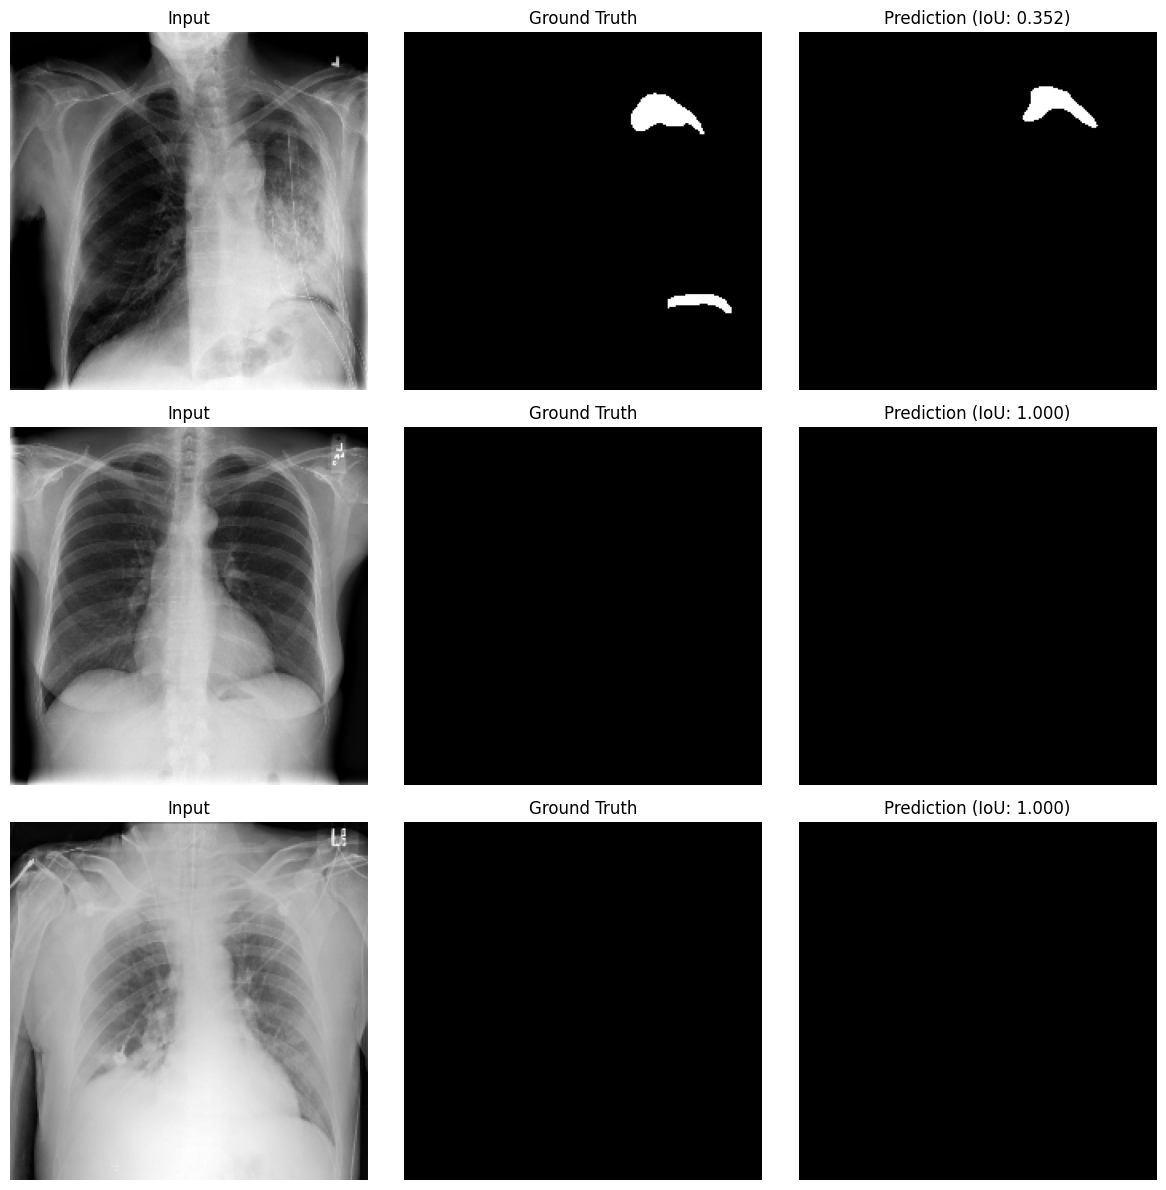

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# خذ batch واحد من test_loader
for images, masks in test_loader:
    images, masks = images[:3].to(device), masks[:3].to(device)
    break

# تنبؤ
with torch.no_grad():
    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5

# تصور 3 صور فقط
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    # الصورة الأصلية
    axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[i, 0].set_title('Input')
    axes[i, 0].axis('off')
    
    # Ground Truth
    axes[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    # التنبؤ
    axes[i, 2].imshow(preds[i].cpu().squeeze(), cmap='gray')
    iou = calculate_iou(outputs[i:i+1], masks[i:i+1])
    axes[i, 2].set_title(f'Prediction (IoU: {iou:.3f})')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('quick_predictions.png', dpi=100)
plt.show()

### Testing the model on a new image

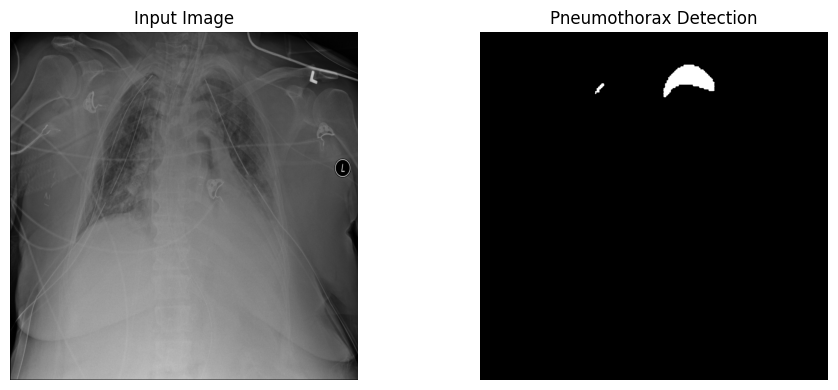

 Test completed


In [58]:
import cv2

def predict_new_image(image_path, model, device='cuda'):
    """تنبؤ على صورة جديدة"""
    # تحميل الصورة
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f" Cannot load {image_path}")
        return None
    
    # حفظ الحجم الأصلي
    original_shape = image.shape
    
    # معالجة
    image_processed = cv2.resize(image, (224, 224))
    image_tensor = torch.from_numpy(image_processed).float() / 255.0
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0).to(device)
    
    # تنبؤ
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.sigmoid(output) > 0.5
    
    # إعادة للقرار الأصلي
    pred_np = prediction.squeeze().cpu().numpy().astype(np.uint8)
    pred_resized = cv2.resize(pred_np, (original_shape[1], original_shape[0]))
    
    # تصور سريع
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred_resized, cmap='gray')
    plt.title('Pneumothorax Detection')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pred_resized

# اختبار (استبدل المسار بصورة لديك)
test_image = "spliting/test/images/1368_test_1_.png"  # غير هذا المسار
if os.path.exists(test_image):
    prediction = predict_new_image(test_image, model, device)
    print(" Test completed")
else:
    print(" No test image found")

In [ ]:
# تنظيف الذاكرة
import gc
torch.cuda.empty_cache()
gc.collect()

print("\n✅ All done! Model is ready for use.")
print("📁 Files created:")
print("  - best_swin_unet.pth (best model)")
print("  - quick_predictions.png (sample predictions)")
print("  - model_report.txt (summary report)")